#Propulsion Plants Decay Evaluation

A propulsion system is a machine that produces thrust to push an object forward.A system which provides thrust to propel the ship. It consists of propulsion machinery and the auxiliary systems needed to operate them, all the equipment to transmit propulsion power into thrust.

We take into consideration **an application of condition-based maintenance to gas turbines used for vessel propulsion**, where the performance and advantages of exploiting statistical/machine learning method(s) in modeling the degradation of the propulsion plant over time are tested. Experiments, conducted on data generated from a sophisticated simulator of a gas turbine, mounted on a Frigate characterized by a COmbined Diesel eLectric And Gas propulsion plant type, will allow to show the effectiveness of the proposed statistical/machine learning approaches and to benchmark them in a realistic maritime application.


#Description of dataset

I assumed that the dataset on which i will trained the model have been developed and fine tuned over the year on several similar real propulsion plants(Gas Turbine propultion plant).

The following quantiles can be derived by exploiting the simulator, punctually describing the state of the system.

* Lever position $(lp)$ [ ]
* Ship speed $(v)$ [knots]
* Gas turbine shaft torque $GTT$
* Gas turbine rate of revolutions $GTn$
* Gas generator rate of revolutions $GGn$
* Starboard propeller torque $Ts$
* Port propeller torque $Tp$
* HP turbine exit temperature $T48$
* GT compressor inlet air temperature $T1$
* GT compressor outlet air temperature $T2$
* HP turbine exit pressure $P48$
* GT compressor inlet air pressure $P1$
* GT compressor outlet air pressure $P2$
* GT exhaust gas pressure $Pexh$
* Turbine injection control $TIC$
* Fuel flow $mf$


In [1]:
import os

In [2]:
os.getcwd()

'/content'

In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')

#Import packages

In [4]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Import and clean the data

In [5]:
#columns=['lp','v','GTT','GTn','GGn','Ts','Tp','T48','T1','T2','P48','P1','P2','Pexh','TIC','mf','kMc','kMt']
df=pd.read_csv('propulsion.csv', index_col=None)
df=df.iloc[:,1:]
df.head()

,Lever position (lp) [ ],Ship speed (v) [knots],Gas Turbine shaft torque (GTT) [kN m],Gas Turbine rate of revolutions (GTn) [rpm],Gas Generator rate of revolutions (GGn) [rpm],Starboard Propeller Torque (Ts) [kN],Port Propeller Torque (Tp) [kN],HP Turbine exit temperature (T48) [C],GT Compressor inlet air temperature (T1) [C],GT Compressor outlet air temperature (T2) [C],HP Turbine exit pressure (P48) [bar],GT Compressor inlet air pressure (P1) [bar],GT Compressor outlet air pressure (P2) [bar],Gas Turbine exhaust gas pressure (Pexh) [bar],Turbine Injecton Control (TIC) [%],Fuel flow (mf) [kg/s],GT Compressor decay state coefficient.,GT Turbine decay state coefficient.
0,9.300,27.0,72762.205,3560.393,9753.812,644.806,644.806,1086.583,288.0,780.304,4.523,0.998,22.879,1.050,90.435,1.790,0.973,0.978
1,6.175,18.0,29760.552,2306.825,8780.012,246.011,246.011,776.921,288.0,665.511,2.518,0.998,13.438,1.030,34.596,0.685,0.995,0.975
2,3.144,9.0,8375.774,1386.739,7051.621,60.318,60.318,589.764,288.0,580.587,1.392,0.998,7.566,1.020,12.477,0.247,0.980,0.978
3,3.144,9.0,8377.589,1386.748,7098.469,60.339,60.339,570.651,288.0,576.565,1.390,0.998,7.409,1.021,11.678,0.231,0.984,1.000
4,6.175,18.0,29761.091,2306.825,8782.024,246.021,246.021,769.855,288.0,663.682,2.518,0.998,13.374,1.031,34.154,0.676,0.998,0.980


##Overview
* The data is clean with no missing values.
* There are 18 columns which consists of 16 features and 2 responses.
* There are 10000 instances on this dataset.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lever position (lp) [ ]                        10000 non-null  float64
 1   Ship speed (v) [knots]                         10000 non-null  float64
 2   Gas Turbine shaft torque (GTT) [kN m]          10000 non-null  float64
 3   Gas Turbine rate of revolutions (GTn) [rpm]    10000 non-null  float64
 4   Gas Generator rate of revolutions (GGn) [rpm]  10000 non-null  float64
 5   Starboard Propeller Torque (Ts) [kN]           10000 non-null  float64
 6   Port Propeller Torque (Tp) [kN]                10000 non-null  float64
 7   HP Turbine exit temperature (T48) [C]          10000 non-null  float64
 8   GT Compressor inlet air temperature (T1) [C]   10000 non-null  float64
 9   GT Compressor outlet air temperature (T2) [C]  1000

In [7]:
df.describe()

,Lever position (lp) [ ],Ship speed (v) [knots],Gas Turbine shaft torque (GTT) [kN m],Gas Turbine rate of revolutions (GTn) [rpm],Gas Generator rate of revolutions (GGn) [rpm],Starboard Propeller Torque (Ts) [kN],Port Propeller Torque (Tp) [kN],HP Turbine exit temperature (T48) [C],GT Compressor inlet air temperature (T1) [C],GT Compressor outlet air temperature (T2) [C],HP Turbine exit pressure (P48) [bar],GT Compressor inlet air pressure (P1) [bar],GT Compressor outlet air pressure (P2) [bar],Gas Turbine exhaust gas pressure (Pexh) [bar],Turbine Injecton Control (TIC) [%],Fuel flow (mf) [kg/s],GT Compressor decay state coefficient.,GT Turbine decay state coefficient.
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.150075,14.951400,27100.647714,2131.151788,8194.182366,225.957785,225.957785,734.476178,288.0,645.748980,2.345732,9.980000e-01,12.262597,1.029402,33.480715,0.659100,0.975021,0.987455
std,2.624015,7.740467,22062.780307,772.211732,1090.569425,199.737886,199.737886,173.009157,0.0,72.483036,1.081038,2.236101e-13,5.320817,0.010353,25.721725,0.504791,0.014734,0.007510
min,1.138000,3.000000,253.547000,1307.675000,6589.002000,5.304000,5.304000,444.731000,288.0,540.999000,1.093000,9.980000e-01,5.828000,1.019000,0.000000,0.068000,0.950000,0.975000
25%,3.144000,9.000000,8375.791500,1386.758000,7056.520500,60.317000,60.317000,589.841000,288.0,577.980750,1.389000,9.980000e-01,7.445000,1.020000,13.534000,0.246000,0.962000,0.981000
50%,5.140000,15.000000,21630.133500,1924.325000,8480.527000,175.264000,175.264000,705.351000,288.0,636.800000,2.082000,9.980000e-01,11.086000,1.026000,25.249500,0.496000,0.975000,0.987000
75%,7.148000,21.000000,39000.710250,2678.078000,9132.132500,332.360000,332.360000,833.154750,288.0,693.656750,2.981000,9.980000e-01,15.649000,1.036000,44.500000,0.881000,0.988000,0.994000
max,9.300000,27.000000,72783.338000,3560.741000,9797.103000,645.249000,645.249000,1115.797000,288.0,789.094000,4.560000,9.980000e-01,23.140000,1.052000,92.556000,1.832000,1.000000,1.000000


##OBSERVATION

* Maximum speed of ship is 27 knot while minimum is 3 knot
* GT Compressor Inlet Air Temperature  T1 have zero-variances.
* Standard deviation of a data set is zero if and only if all of its values are identical. This means they are constant numbers(also pointed above while finding number of uniques).
* T1 will be removed from the data.

Check duplicate rows in dataset.

In [8]:
df.duplicated().sum()

0

The data is clean with no missing values.

In [9]:
np,df.isnull().sum()

(<module 'numpy' from '/usr/local/lib/python3.6/dist-packages/numpy/__init__.py'>,
 Lever position (lp) [ ]                          0
 Ship speed (v) [knots]                           0
 Gas Turbine shaft torque (GTT) [kN m]            0
 Gas Turbine rate of revolutions (GTn) [rpm]      0
 Gas Generator rate of revolutions (GGn) [rpm]    0
 Starboard Propeller Torque (Ts) [kN]             0
 Port Propeller Torque (Tp) [kN]                  0
 HP Turbine exit temperature (T48) [C]            0
 GT Compressor inlet air temperature (T1) [C]     0
 GT Compressor outlet air temperature (T2) [C]    0
 HP Turbine exit pressure (P48) [bar]             0
 GT Compressor inlet air pressure (P1) [bar]      0
 GT Compressor outlet air pressure (P2) [bar]     0
 Gas Turbine exhaust gas pressure (Pexh) [bar]    0
 Turbine Injecton Control (TIC) [%]               0
 Fuel flow (mf) [kg/s]                            0
 GT Compressor decay state coefficient.           0
 GT Turbine decay state coefficie

#Check the linearity between $lp$ and $v$
We can see the **R-squared** is exactly 1, and the coefficient of linear model is approximately 3 with standard error is zero.
$lp$ will be removed from the data

In [10]:
LiR_v = sm.OLS(df['Lever position (lp) [ ]'], sm.add_constant(df['Ship speed (v) [knots]'])).fit()
LiR_v.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Lever position (lp) [ ]   R-squared:                       1.000
Model:                                 OLS   Adj. R-squared:                  1.000
Method:                      Least Squares   F-statistic:                 5.898e+07
Date:                     Wed, 18 Nov 2020   Prob (F-statistic):               0.00
Time:                             15:51:03   Log-Likelihood:                 19577.
No. Observations:                    10000   AIC:                        -3.915e+04
Df Residuals:                         9998   BIC:                        -3.914e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0820      0.001    110.326      0.000       0.081       0.083
Ship speed (v) [knots]     0.3390   4.41e-05   7679.646      0.000       0.339       0.339
==============================================================================
Omnibus:                      595.771   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              455.793
Skew:                           0.431   Prob(JB):                     1.06e-99
Kurtosis:                       2.407   Cond. No.                         36.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Remove redundant features
We will remove three features from the data: $lp$, $T1$

In [11]:
df.drop(['Lever position (lp) [ ]','GT Compressor inlet air temperature (T1) [C]'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Ship speed (v) [knots]                         10000 non-null  float64
 1   Gas Turbine shaft torque (GTT) [kN m]          10000 non-null  float64
 2   Gas Turbine rate of revolutions (GTn) [rpm]    10000 non-null  float64
 3   Gas Generator rate of revolutions (GGn) [rpm]  10000 non-null  float64
 4   Starboard Propeller Torque (Ts) [kN]           10000 non-null  float64
 5   Port Propeller Torque (Tp) [kN]                10000 non-null  float64
 6   HP Turbine exit temperature (T48) [C]          10000 non-null  float64
 7   GT Compressor outlet air temperature (T2) [C]  10000 non-null  float64
 8   HP Turbine exit pressure (P48) [bar]           10000 non-null  float64
 9   GT Compressor inlet air pressure (P1) [bar]    1000

Creating **Heatmap** and find correlation

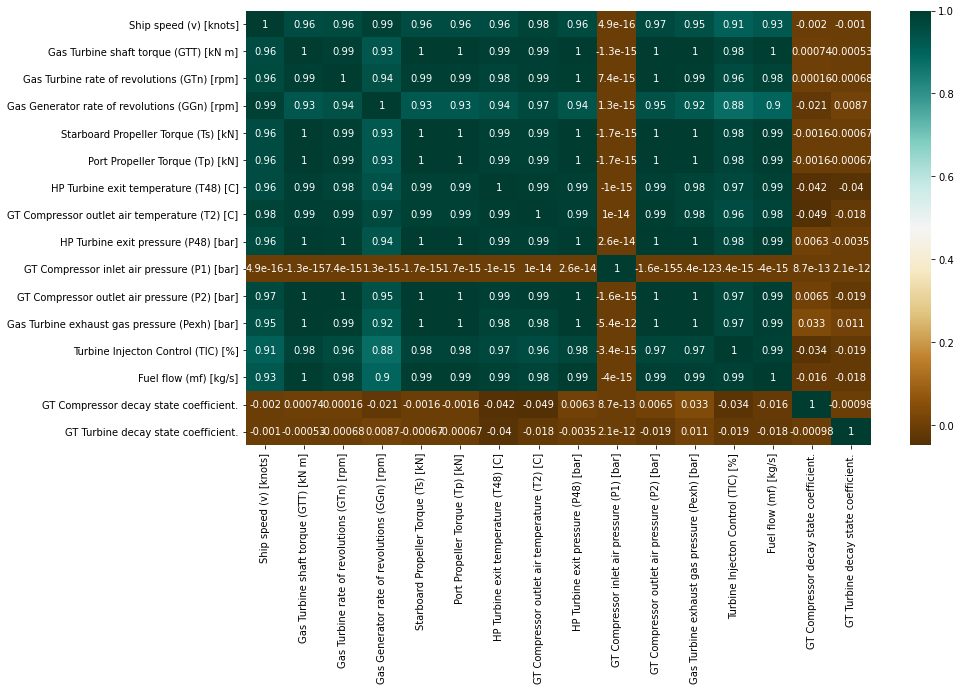

In [13]:
plt.figure(figsize=(14,8))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)

Now we will remove features from the data:  **$P1$** becouse it is correlated with other features highly negative.

In [14]:
df.drop(['GT Compressor inlet air pressure (P1) [bar]'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Ship speed (v) [knots]                         10000 non-null  float64
 1   Gas Turbine shaft torque (GTT) [kN m]          10000 non-null  float64
 2   Gas Turbine rate of revolutions (GTn) [rpm]    10000 non-null  float64
 3   Gas Generator rate of revolutions (GGn) [rpm]  10000 non-null  float64
 4   Starboard Propeller Torque (Ts) [kN]           10000 non-null  float64
 5   Port Propeller Torque (Tp) [kN]                10000 non-null  float64
 6   HP Turbine exit temperature (T48) [C]          10000 non-null  float64
 7   GT Compressor outlet air temperature (T2) [C]  10000 non-null  float64
 8   HP Turbine exit pressure (P48) [bar]           10000 non-null  float64
 9   GT Compressor outlet air pressure (P2) [bar]   1000

#**Train Models**
## Split Data to Training and Test sets
* There are 9.547 (80%) instances used to fit the models.
* The remains of instances (20%) will be used to compute the accuracy scores of models to avoid **overfitting**.

In [23]:
X=df.iloc[:,:13]
y1=df.iloc[:,13:14]
y2=df.iloc[:,14:]
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X,y1,y2,test_size=0.2,random_state=13)

In [25]:
print('X_train shape =',X_train.shape)
print('X_test shape =',X_test.shape)
print('y1_train shape =',y1_train.shape)
print('y1_test shape =',y1_test.shape)
print('y2_train shape =',y2_train.shape)
print('y2_test shape =',y2_test.shape)

X_train shape = (8000, 13)
X_test shape = (2000, 13)
y1_train shape = (8000, 1)
y1_test shape = (2000, 1)
y2_train shape = (8000, 1)
y2_test shape = (2000, 1)


#Train the models to predict $y1$
Linear Regression Model

R-squared = 0.791
All coefficients are significant (nonzero) according to t-test

In [26]:
LiR_y1 = sm.OLS(y1_train, sm.add_constant(X_train)).fit()
LiR_y1_pred = LiR_y1.predict(sm.add_constant(X_test))
LiR_y1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     GT Compressor decay state coefficient.   R-squared:                       0.791
Model:                                                OLS   Adj. R-squared:                  0.790
Method:                                     Least Squares   F-statistic:                     2514.
Date:                                    Wed, 18 Nov 2020   Prob (F-statistic):               0.00
Time:                                            16:06:05   Log-Likelihood:                 28632.
No. Observations:                                    8000   AIC:                        -5.724e+04
Df Residuals:                                        7987   BIC:                        -5.715e+04
Df Model:                                              12                                         
Covariance Type:                                nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             4.4877      0.257     17.442      0.000       3.983       4.992
Ship speed (v) [knots]                            0.0044      0.000     21.204      0.000       0.004       0.005
Gas Turbine shaft torque (GTT) [kN m]          5.066e-06   4.54e-07     11.166      0.000    4.18e-06    5.96e-06
Gas Turbine rate of revolutions (GTn) [rpm]      -0.0001   3.39e-06    -34.493      0.000      -0.000      -0.000
Gas Generator rate of revolutions (GGn) [rpm]  1.683e-05    1.1e-06     15.297      0.000    1.47e-05     1.9e-05
Starboard Propeller Torque (Ts) [kN]             -0.0006   2.08e-05    -27.266      0.000      -0.001      -0.001
Port Propeller Torque (Tp) [kN]                  -0.0006   2.08e-05    -27.266      0.000      -0.001      -0.001
HP Turbine exit temperature (T48) [C]            -0.0002   2.53e-05     -9.340      0.000      -0.000      -0.000
GT Compressor outlet air temperature (T2) [C]    -0.0023   3.27e-05    -71.666      0.000      -0.002      -0.002
HP Turbine exit pressure (P48) [bar]              0.2243      0.012     18.061      0.000       0.200       0.249
GT Compressor outlet air pressure (P2) [bar]      0.0254      0.001     23.811      0.000       0.023       0.028
Gas Turbine exhaust gas pressure (Pexh) [bar]    -2.4421      0.251     -9.738      0.000      -2.934      -1.950
Turbine Injecton Control (TIC) [%]               -0.0005   2.25e-05    -21.726      0.000      -0.001      -0.000
Fuel flow (mf) [kg/s]                             0.0467      0.015      3.042      0.002       0.017       0.077
==============================================================================
Omnibus:                      199.135   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.347
Skew:                           0.111   Prob(JB):                     6.63e-25
Kurtosis:                       2.467   Cond. No.                     4.21e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.76e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [27]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y1_train)
y1_pred= linear_reg.predict(X_test)
print("Accuracy on Traing set: ",linear_reg.score(X_train,y1_train))
print("Accuracy on Testing set: ",linear_reg.score(X_test,y1_test))

Accuracy on Traing set:  0.7906786706617417
Accuracy on Testing set:  0.7940914151500997


##Random Forest Regressor for $y1$

In [31]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train, y1_train)
y1_pred= rf_reg.predict(X_test)
print("Accuracy on Traing set: ",rf_reg.score(X_train,y1_train))
print("Accuracy on Testing set: ",rf_reg.score(X_test,y1_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy on Traing set:  0.9992460361629218
Accuracy on Testing set:  0.9944579194309855


Find r2_score,mean_squared_error,mean_absolute_error from random forest regressor for  $y1$

In [33]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
import math

print("R2_Score : ", r2_score(y1_test,y1_pred))
print("Mean Squared Error : ", mean_squared_error(y1_test,y1_pred))
print("MAE : ",mean_absolute_error(y1_test,y1_pred))
print("RSME : ",math.sqrt(mean_squared_error(y1_test,y1_pred)))

R2_Score :  0.9944579194309855
Mean Squared Error :  1.1873278925493722e-06
MAE :  0.0005741163459700595
RSME :  0.0010896457647095097


#Train the models to predict $y2$
Train the Linear Regression model

R-squared = 0.910
All coefficients are significant (nonzero) according to t-test

In [35]:
LiR_y2 = sm.OLS(y2_train, sm.add_constant(X_train)).fit()
LiR_y2_pred = LiR_y2.predict(sm.add_constant(X_test))
LiR_y2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     GT Turbine decay state coefficient.   R-squared:                       0.910
Model:                                             OLS   Adj. R-squared:                  0.910
Method:                                  Least Squares   F-statistic:                     6742.
Date:                                 Wed, 18 Nov 2020   Prob (F-statistic):               0.00
Time:                                         16:12:09   Log-Likelihood:                 37418.
No. Observations:                                 8000   AIC:                        -7.481e+04
Df Residuals:                                     7987   BIC:                        -7.472e+04
Df Model:                                           12                                         
Covariance Type:                             nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             0.0487      0.086      0.567      0.570      -0.120       0.217
Ship speed (v) [knots]                            0.0061   6.94e-05     87.467      0.000       0.006       0.006
Gas Turbine shaft torque (GTT) [kN m]           1.38e-05   1.51e-07     91.222      0.000    1.35e-05    1.41e-05
Gas Turbine rate of revolutions (GTn) [rpm]    6.482e-05   1.13e-06     57.390      0.000    6.26e-05     6.7e-05
Gas Generator rate of revolutions (GGn) [rpm]  3.116e-05   3.67e-07     84.932      0.000    3.04e-05    3.19e-05
Starboard Propeller Torque (Ts) [kN]             -0.0008   6.95e-06   -113.105      0.000      -0.001      -0.001
Port Propeller Torque (Tp) [kN]                  -0.0008   6.95e-06   -113.105      0.000      -0.001      -0.001
HP Turbine exit temperature (T48) [C]            -0.0007   8.44e-06    -80.257      0.000      -0.001      -0.001
GT Compressor outlet air temperature (T2) [C]     0.0002   1.09e-05     18.441      0.000       0.000       0.000
HP Turbine exit pressure (P48) [bar]              0.0805      0.004     19.438      0.000       0.072       0.089
GT Compressor outlet air pressure (P2) [bar]     -0.0536      0.000   -150.535      0.000      -0.054      -0.053
Gas Turbine exhaust gas pressure (Pexh) [bar]     1.0168      0.084     12.158      0.000       0.853       1.181
Turbine Injecton Control (TIC) [%]               -0.0002   7.51e-06    -30.038      0.000      -0.000      -0.000
Fuel flow (mf) [kg/s]                             0.3533      0.005     68.959      0.000       0.343       0.363
==============================================================================
Omnibus:                      262.235   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              666.107
Skew:                           0.123   Prob(JB):                    2.27e-145
Kurtosis:                       4.392   Cond. No.                     4.21e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.76e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [36]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y2_train)
y2_pred= linear_reg.predict(X_test)
print("Accuracy on Traing set: ",linear_reg.score(X_train,y2_train))
print("Accuracy on Testing set: ",linear_reg.score(X_test,y2_test))

Accuracy on Traing set:  0.9101539706927426
Accuracy on Testing set:  0.9150652555613592


###Random Forest Regressor

In [37]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train, y2_train)
y2_pred= rf_reg.predict(X_test)
print("Accuracy on Traing set: ",rf_reg.score(X_train,y2_train))
print("Accuracy on Testing set: ",rf_reg.score(X_test,y2_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy on Traing set:  0.9983555001323531
Accuracy on Testing set:  0.986607684158917


Find r2_score,mean_squared_error,mean_absolute_error from random forest regressor for $y2$

In [38]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
import math

print("R2_Score : ", r2_score(y2_test,y2_pred))
print("Mean Squared Error : ", mean_squared_error(y2_test,y2_pred))
print("MAE : ",mean_absolute_error(y2_test,y2_pred))
print("RSME : ",math.sqrt(mean_squared_error(y2_test,y2_pred)))

R2_Score :  0.986607684158917
Mean Squared Error :  7.536121258150292e-07
MAE :  0.00040413286148981197
RSME :  0.0008681083606411294
